# Flight DataSet-Time Series

This Python code analyzes a time series dataset of flight passengers, aiming to understand the trends, seasonality, and patterns in the data. The analysis includes visualizations, decomposition techniques, stationarity tests, detrending, autocorrelation analysis, and building a SARIMAX model for predicting future passenger counts.

The dataset contains information about the number of passengers across different months and years. The code systematically explores various aspects of the time series data to derive insights and make predictions.


## Data Preparation and Visualization

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from dateutil.parser import parse
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

## Set plot configurations

In [3]:
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

## Functions

In [4]:
# Function to load and preprocess data
def load_and_preprocess_data(file_path):
    """Load and preprocess the time series data."""
    df = pd.read_csv(file_path, parse_dates=['Month'])
    df = df.rename(columns={'Month': 'Date'})
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    return df

# Function to plot seasonal data
def plot_seasonal_data(df):
    """Plot the seasonal data."""
    plt.plot(df['Passengers'])
    plt.title('Seasonal Plot of Flight Time Series')
    plt.xlabel('Month')
    plt.ylabel('Number Of Passengers')
    plt.show()

# Function for seasonal decomposition
def seasonal_decomposition(df, model_type='multiplicative'):
    """Perform seasonal decomposition and visualize the results."""
    result = seasonal_decompose(df['Passengers'], model=model_type, extrapolate_trend='freq')
    result.plot().suptitle(f'{model_type.capitalize()} Decomposition', fontsize=8)
    plt.show()
    return result

# Function for stationarity tests
def stationarity_tests(series):
    """Perform ADF and KPSS tests for stationarity."""
    # ADF Test
    result_adf = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result_adf[0]}')
    print(f'p-value: {result_adf[1]}')
    for key, value in result_adf[4].items():
        print(f'   {key}, {value}')
    if result_adf[0] > 0.05:
        print('The time series is not stationary')

    # KPSS Test
    result_kpss = kpss(series, regression='c')
    print('\nKPSS Statistic: %f' % result_kpss[1])
    print('p-value: %f' % result_kpss[1])
    for key, value in result_kpss[3].items():
        print(f'   {key}, {value}')
    if result_kpss[1] < 0.05:
        print('The time series is not trend stationary')
    else:
        print('The time series is trend stationary')

# Function for detrending and checking stationarity
def detrend_and_check_stationarity(series, trend_component):
    """Detrend the series and perform stationarity tests."""
    detrended = series / trend_component
    # ADF Test
    result_adf = adfuller(detrended.values, autolag='AIC')
    print(f'ADF Statistic: {result_adf[0]}')
    print(f'p-value: {result_adf[1]}')
    for key, value in result_adf[4].items():
        print(f'   {key}, {value}')
    if result_adf[0] > 0.05:
        print('The time series is not stationary')
    else:
        print('The time series is stationary')

    # KPSS Test
    result_kpss = kpss(detrended.values, regression='c')
    print('\nKPSS Statistic: %f' % result_kpss[1])
    print('p-value: %f' % result_kpss[1])
    for key, value in result_kpss[3].items():
        print(f'   {key}, {value}')
    if result_kpss[1] < 0.05:
        print('The time series is not trend stationary')
    else:
        print('The time series is trend stationary')

# Function for ACF and PACF analysis
def acf_pacf_analysis(series, lags=50):
    """Calculate and plot ACF and PACF."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)
    plot_acf(series, lags=lags, ax=axes[0])
    plot_pacf(series, lags=lags, ax=axes[1], method='ywm')
    plt.show()

# Function to build a SARIMAX model and make predictions
def sarimax_model_and_prediction(series, order, seasonal_order, start, end):
    """Build a SARIMAX model and make predictions."""
    model_sarimax = SARIMAX(series, order=order, seasonal_order=seasonal_order,
                            enforce_invertibility=False, enforce_stationarity=False)
    model = model_sarimax.fit()
    yhat = model.predict(start=start, end=end, dynamic=True)
    return yhat

## Load and preprocess data

In [5]:
file_path = 'Flight.csv'
df = load_and_preprocess_data(file_path)

##  Stack all years above each other and plot them

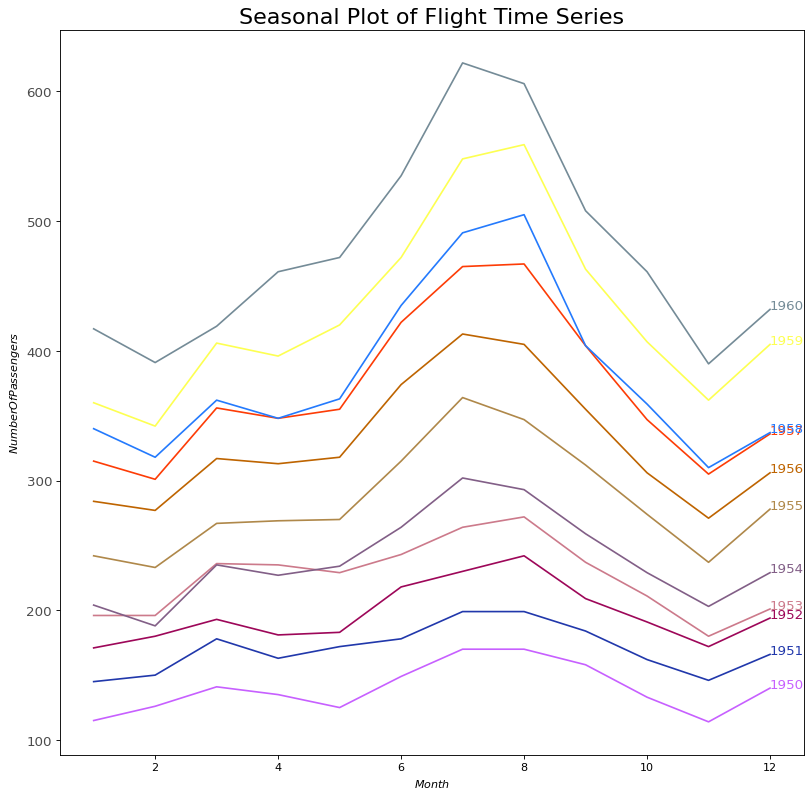

In [6]:
# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.month for d in df.index]
years = df['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(12,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:    
        plt.plot('month', 'Passengers', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0], df.loc[df.year==y, 'Passengers'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(ylabel='$Number Of Passengers$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Flight Time Series", fontsize=20)
plt.show()

## Plot seasonal data

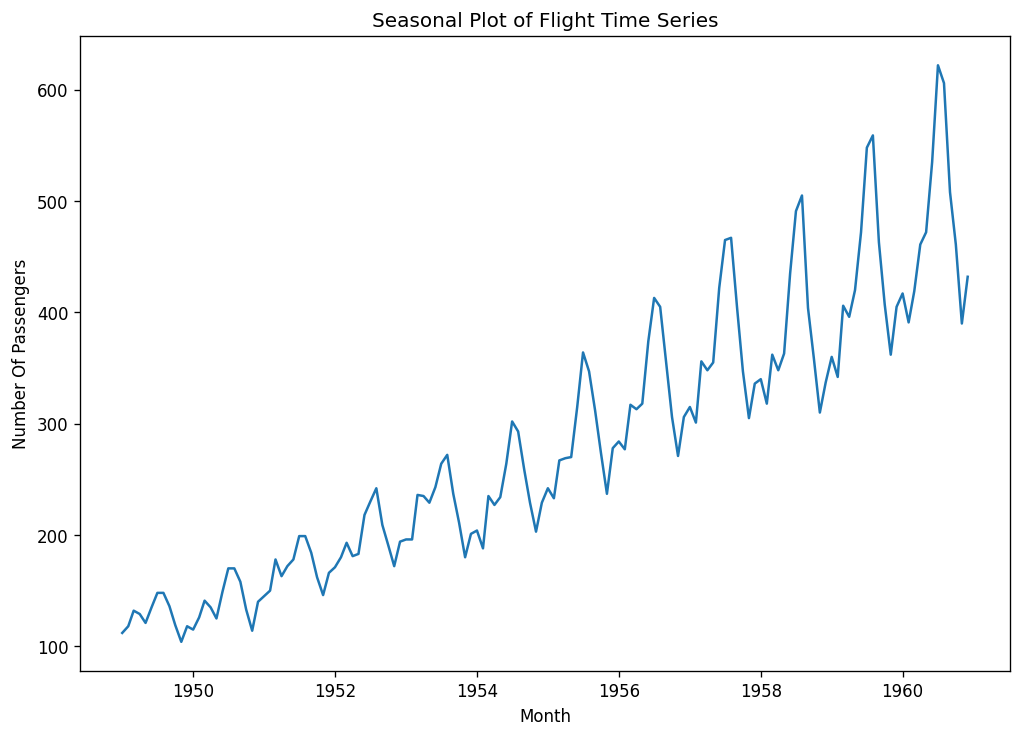

In [7]:
plot_seasonal_data(df)

## Seasonal decomposition

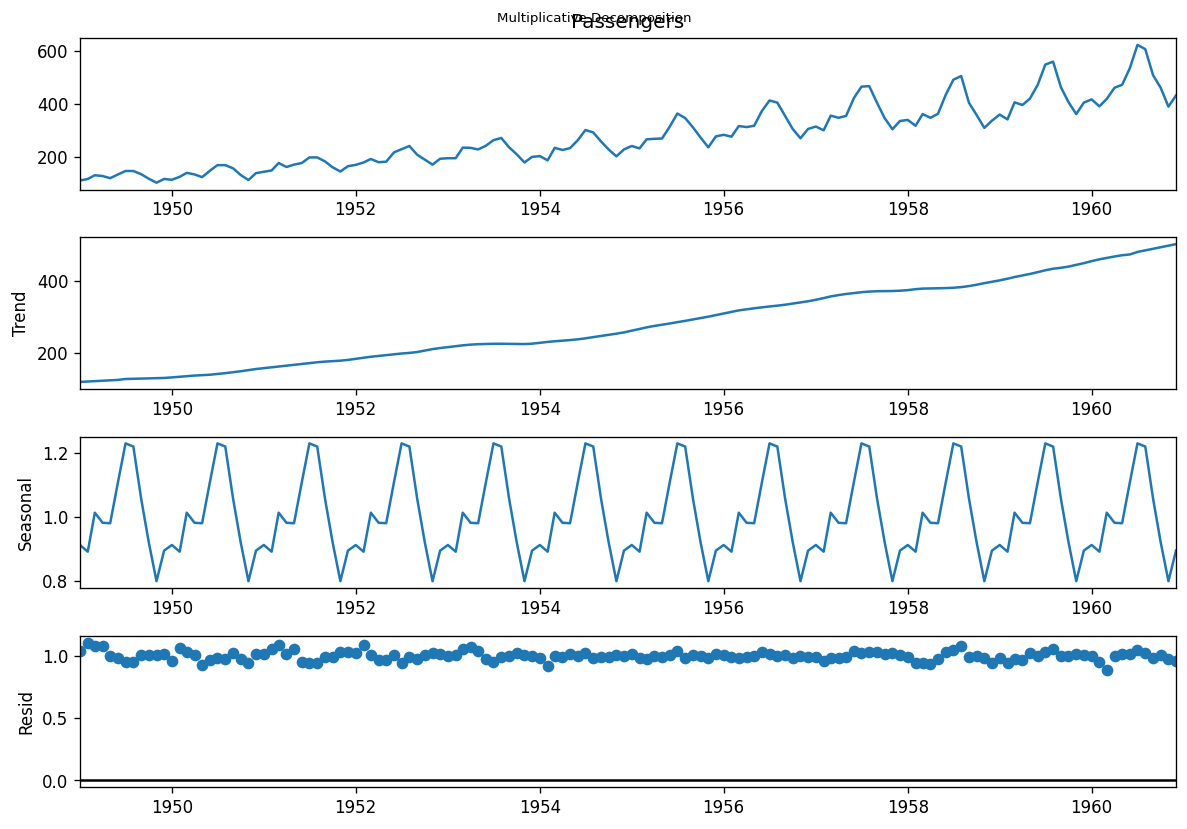

In [8]:
seasonal_decomposition(df)

## Seasonality Tests

In [9]:
stationarity_tests(df['Passengers'].values)

ADF Statistic: 0.8153688792060482
p-value: 0.991880243437641
   1%, -3.4816817173418295
   5%, -2.8840418343195267
   10%, -2.578770059171598
The time series is not stationary

KPSS Statistic: 0.010000
p-value: 0.010000
   10%, 0.347
   5%, 0.463
   2.5%, 0.574
   1%, 0.739
The time series is not trend stationary


## Detrending

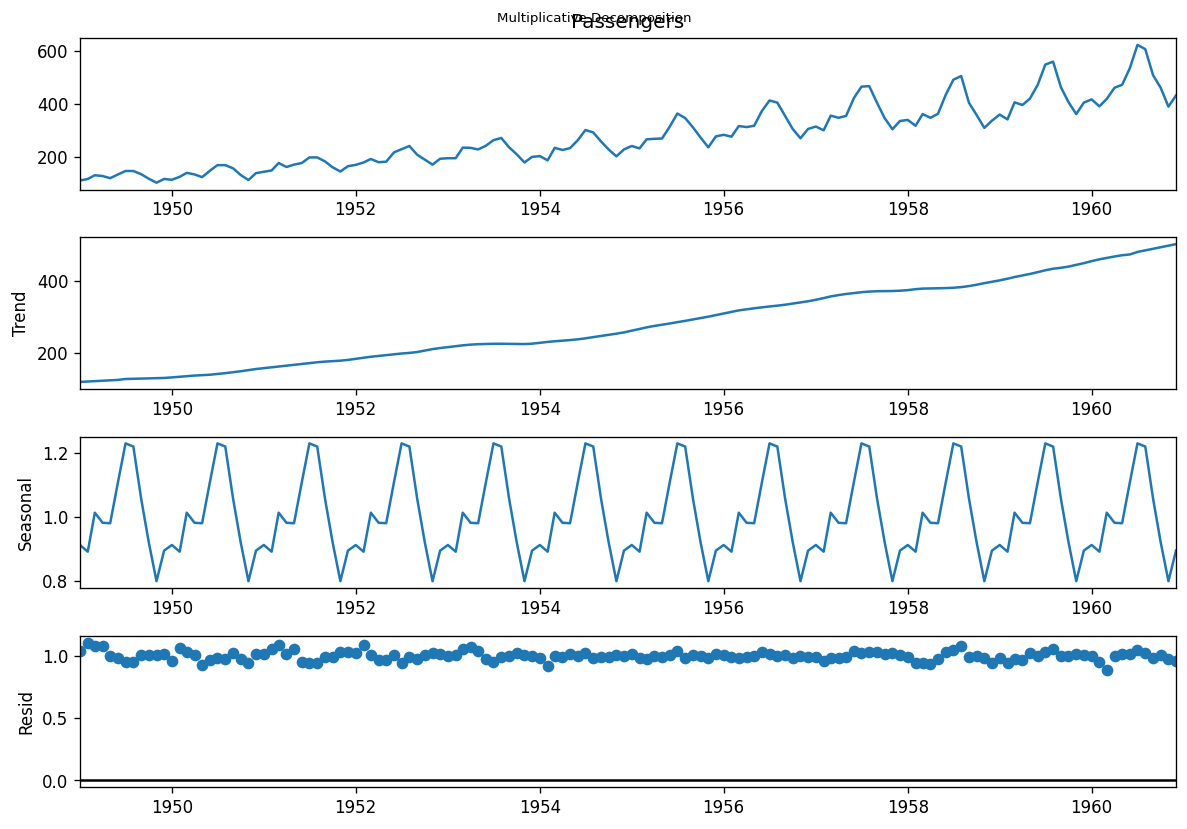

ADF Statistic: -3.9002126164724715
p-value: 0.002033282923242176
   1%, -3.482087964046026
   5%, -2.8842185101614626
   10%, -2.578864381347275
The time series is stationary

KPSS Statistic: 0.100000
p-value: 0.100000
   10%, 0.347
   5%, 0.463
   2.5%, 0.574
   1%, 0.739
The time series is trend stationary


In [10]:
trend_component = seasonal_decomposition(df, model_type='multiplicative').trend
detrend_and_check_stationarity(df['Passengers'], trend_component)

In [11]:
## Plotting Detrending

Text(0.5, 1.0, 'Flight data detrended by subtracting the trend component')

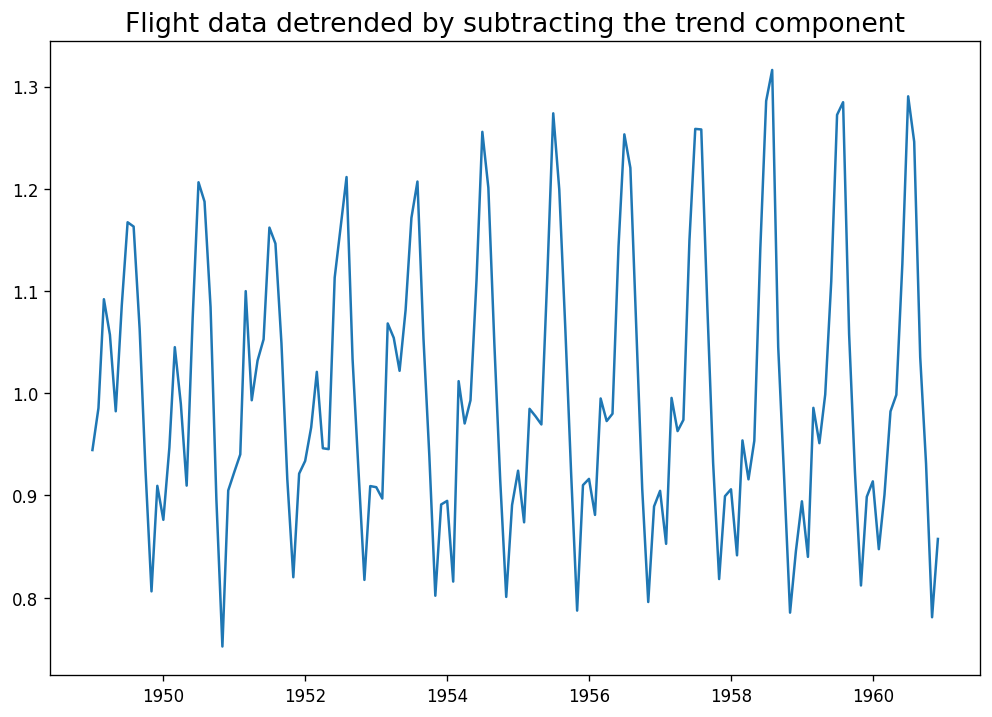

In [12]:
detrended = df['Passengers'].values / trend_component
plt.plot(detrended)
plt.title('Flight data detrended by subtracting the trend component', fontsize=16)

## Autocorrelation and Partial Autocorrelation before and after detrending

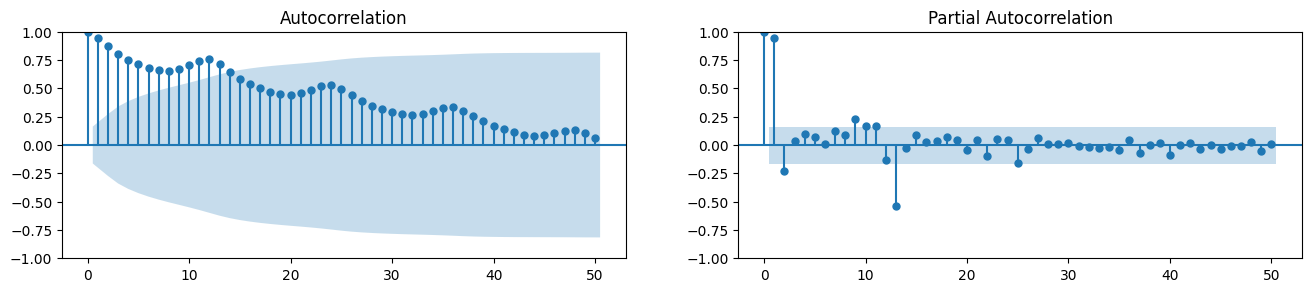

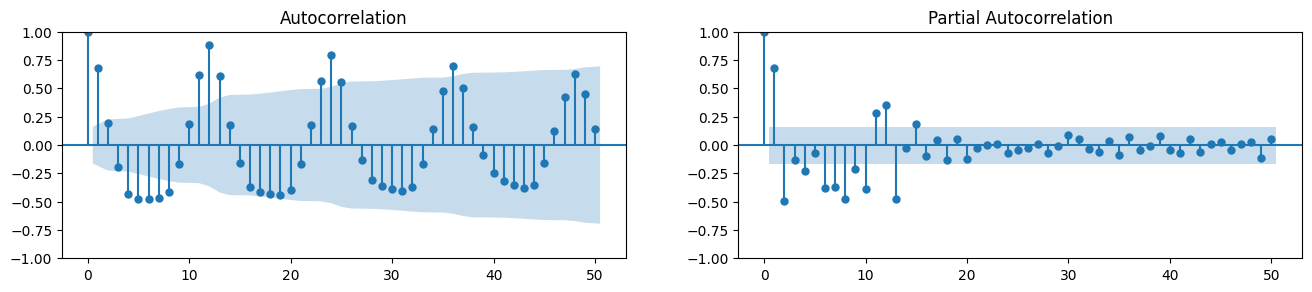

In [13]:
acf_pacf_analysis(df['Passengers'])
acf_pacf_analysis(detrended)

## Build a SARIMAX model and predict

In [14]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)
start, end = 133, 133 + 36
yhat = sarimax_model_and_prediction(df[:'1959-12']['Passengers'], order, seasonal_order, start, end)

## Plot the results

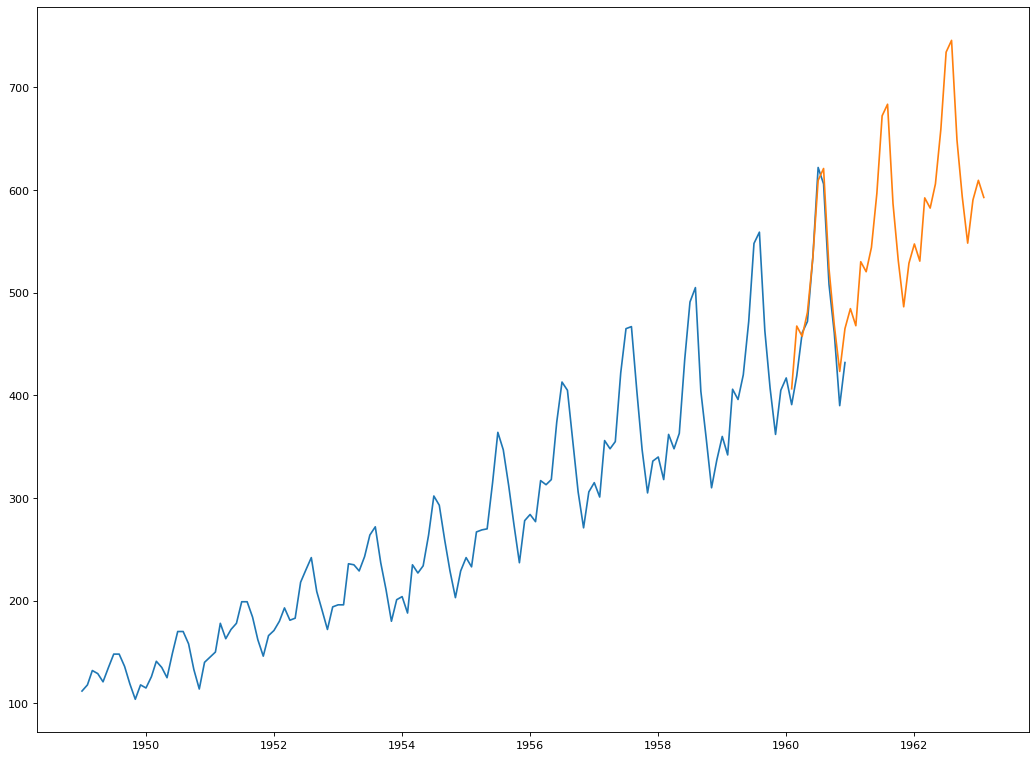

In [15]:
plt.figure(figsize=(16, 12), dpi=80)
plt.plot(df['Passengers'])
plt.plot(yhat)
plt.show()